In [3]:
import pandas as pd

insurance = pd.read_csv('insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


2. Exploratory Data Analysis.

a) Convert all the data to numeric values.

In [4]:
import numpy as np

def convert_to_numerical(df):

  df["north"] = [int(region[0:5] == "north") for region in df["region"]]
  df["west"] = [int(region[5:] == "west") for region in df["region"]]
  for column in df.columns:
    if df[column].dtype == type(object):
      df[column] = df[column].astype('category').cat.codes
  df = df.drop('region', axis=1)
  return df

numerical_insurance = convert_to_numerical(insurance)
numerical_insurance[:10]

,age,sex,bmi,children,smoker,charges,north,west
0,19,0,27.900,0,1,16884.92400,0,1
1,18,1,33.770,1,0,1725.55230,0,0
2,28,1,33.000,3,0,4449.46200,0,0
3,33,1,22.705,0,0,21984.47061,1,1
4,32,1,28.880,0,0,3866.85520,1,1
5,31,0,25.740,0,0,3756.62160,0,0
6,46,0,33.440,1,0,8240.58960,0,0
7,37,0,27.740,3,0,7281.50560,1,1
8,37,1,29.830,2,0,6406.41070,1,0
9,60,0,25.840,0,0,28923.13692,1,1



b) Check if there are any missing/NULL values

In [5]:
def check_sanity(df):
  columns = [row[1].items() for row in df.items()]
  value_matrix = [[value[1] for value in list(t)] for t in columns]
  values = np.asarray(value_matrix).ravel()
  return np.isnan(values).any()

check_sanity(numerical_insurance)

False


c) Obtain the histogram of each feature, using:

a. Bar plots

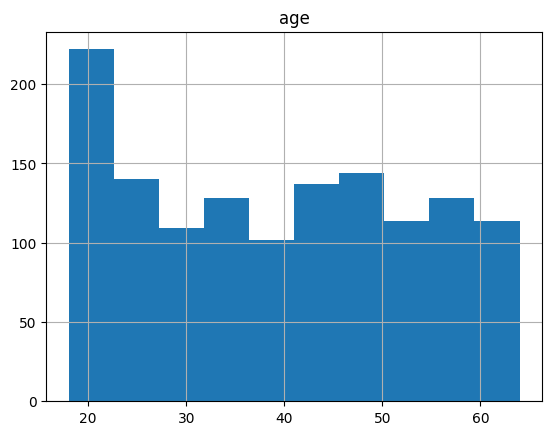

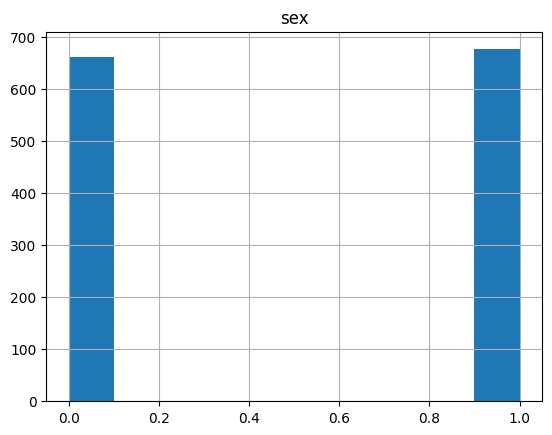

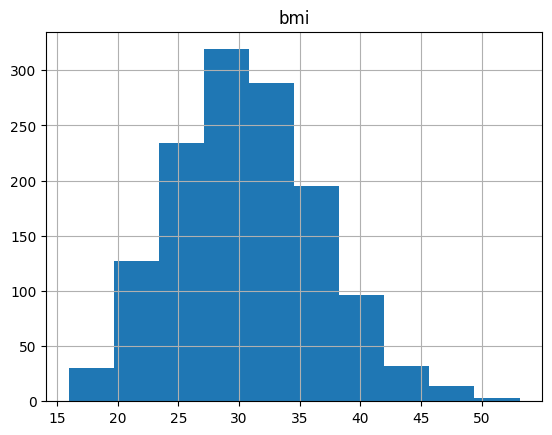

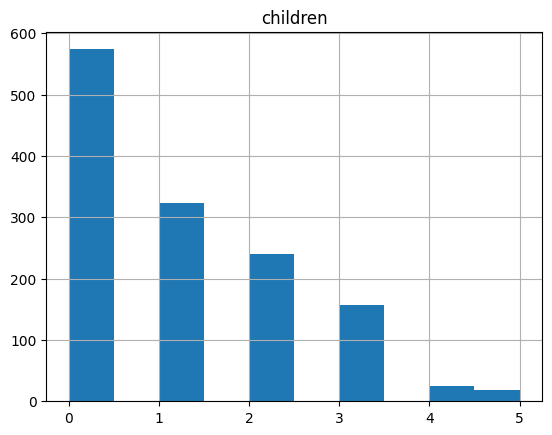

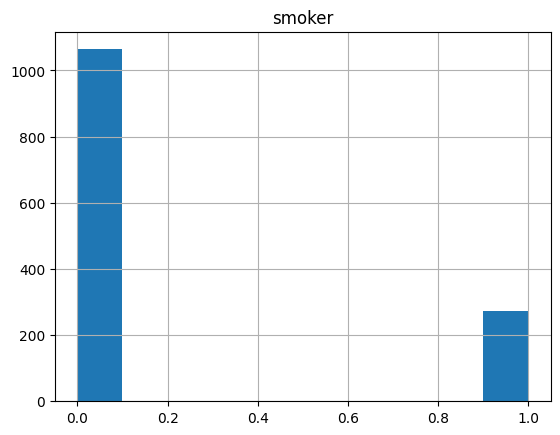

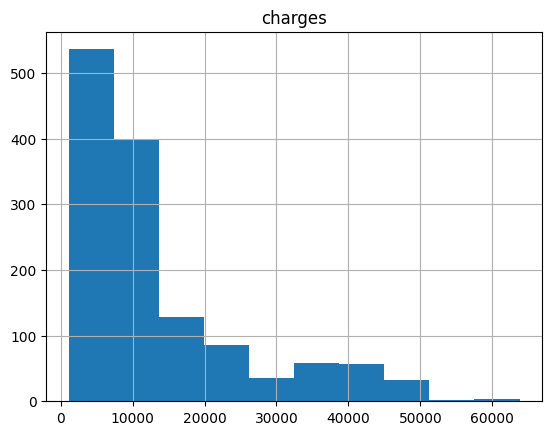

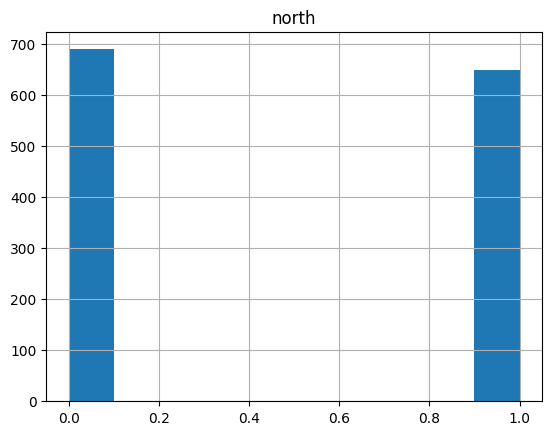

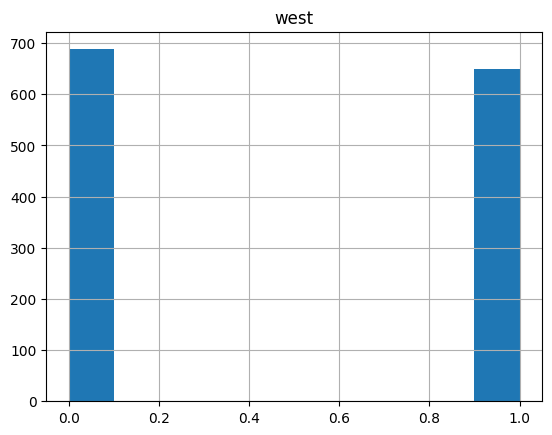

In [6]:
import matplotlib.pyplot as plt

def plot_histograms_bar(df):
  for column in df.columns:
    plt.figure()
    df[column].hist()
    plt.title(column)
    plt.show()
    print()

plot_histograms_bar(numerical_insurance)

b. Density estimates

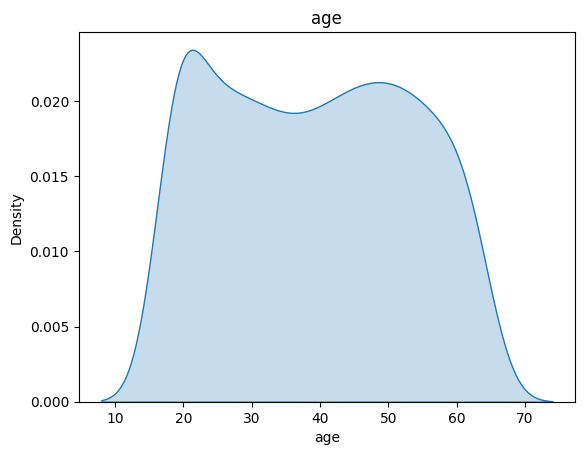

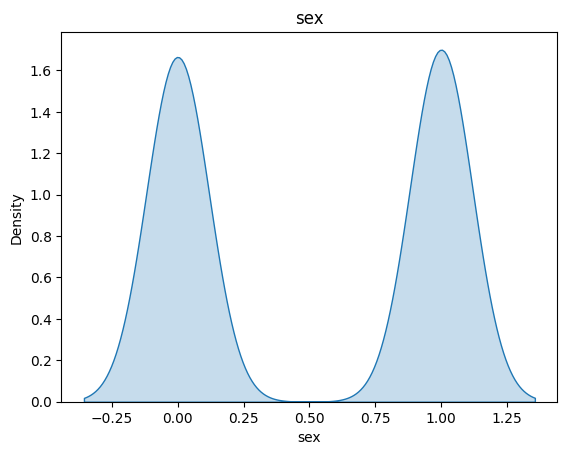

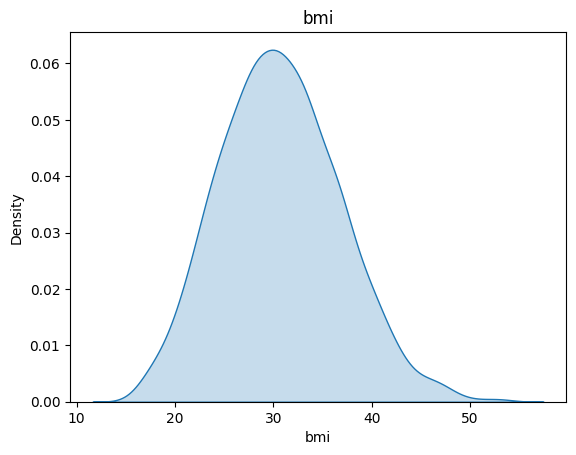

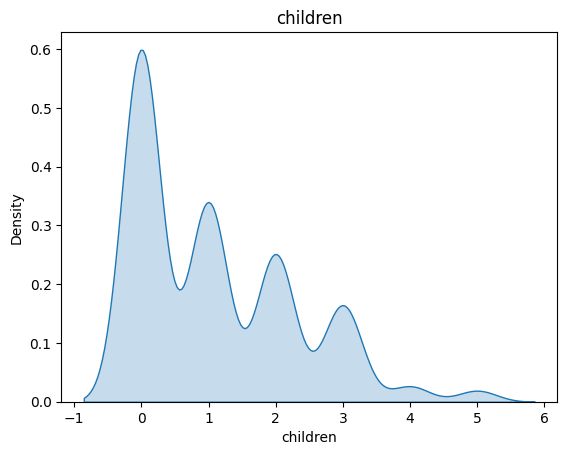

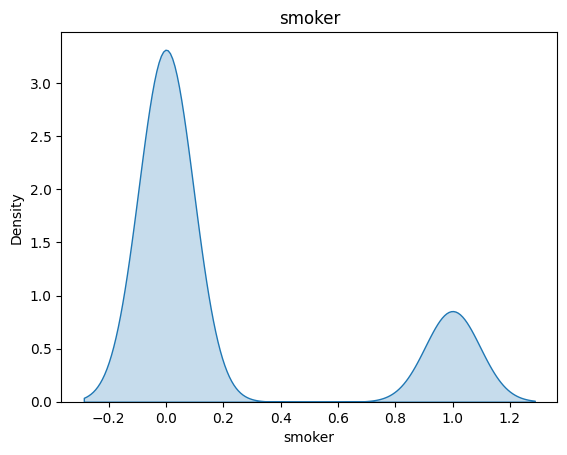

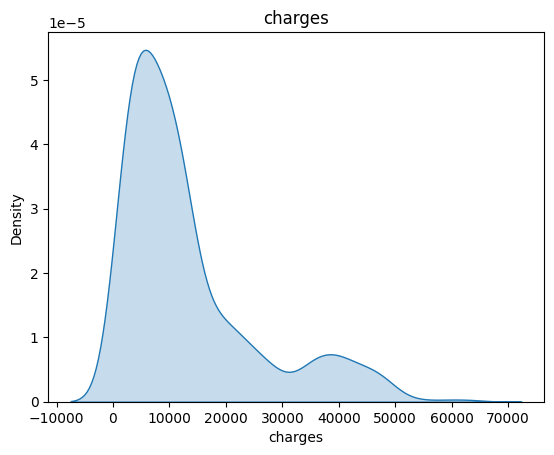

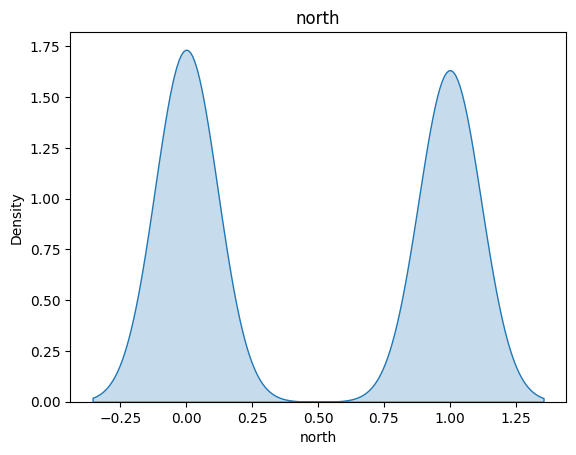

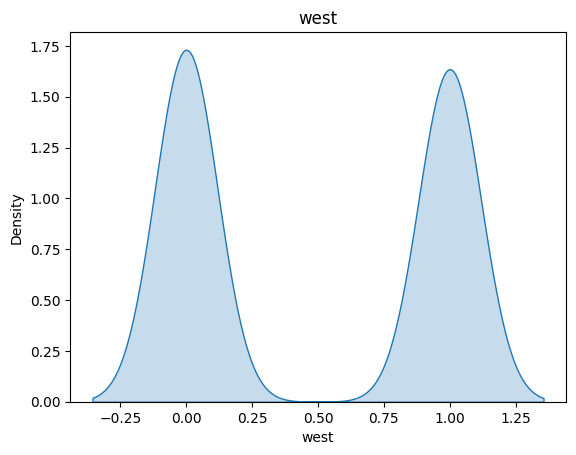

In [7]:
import seaborn as sns

def plot_histograms_density_estimates(df):
  for column in df.columns:
    plt.figure()
    sns.kdeplot(df[column], fill=True)
    plt.title(column)
    plt.show()
    print()

plot_histograms_density_estimates(numerical_insurance)


d) Analyze the correlation between features:


a. Observing the scatter plots between pairs of features.

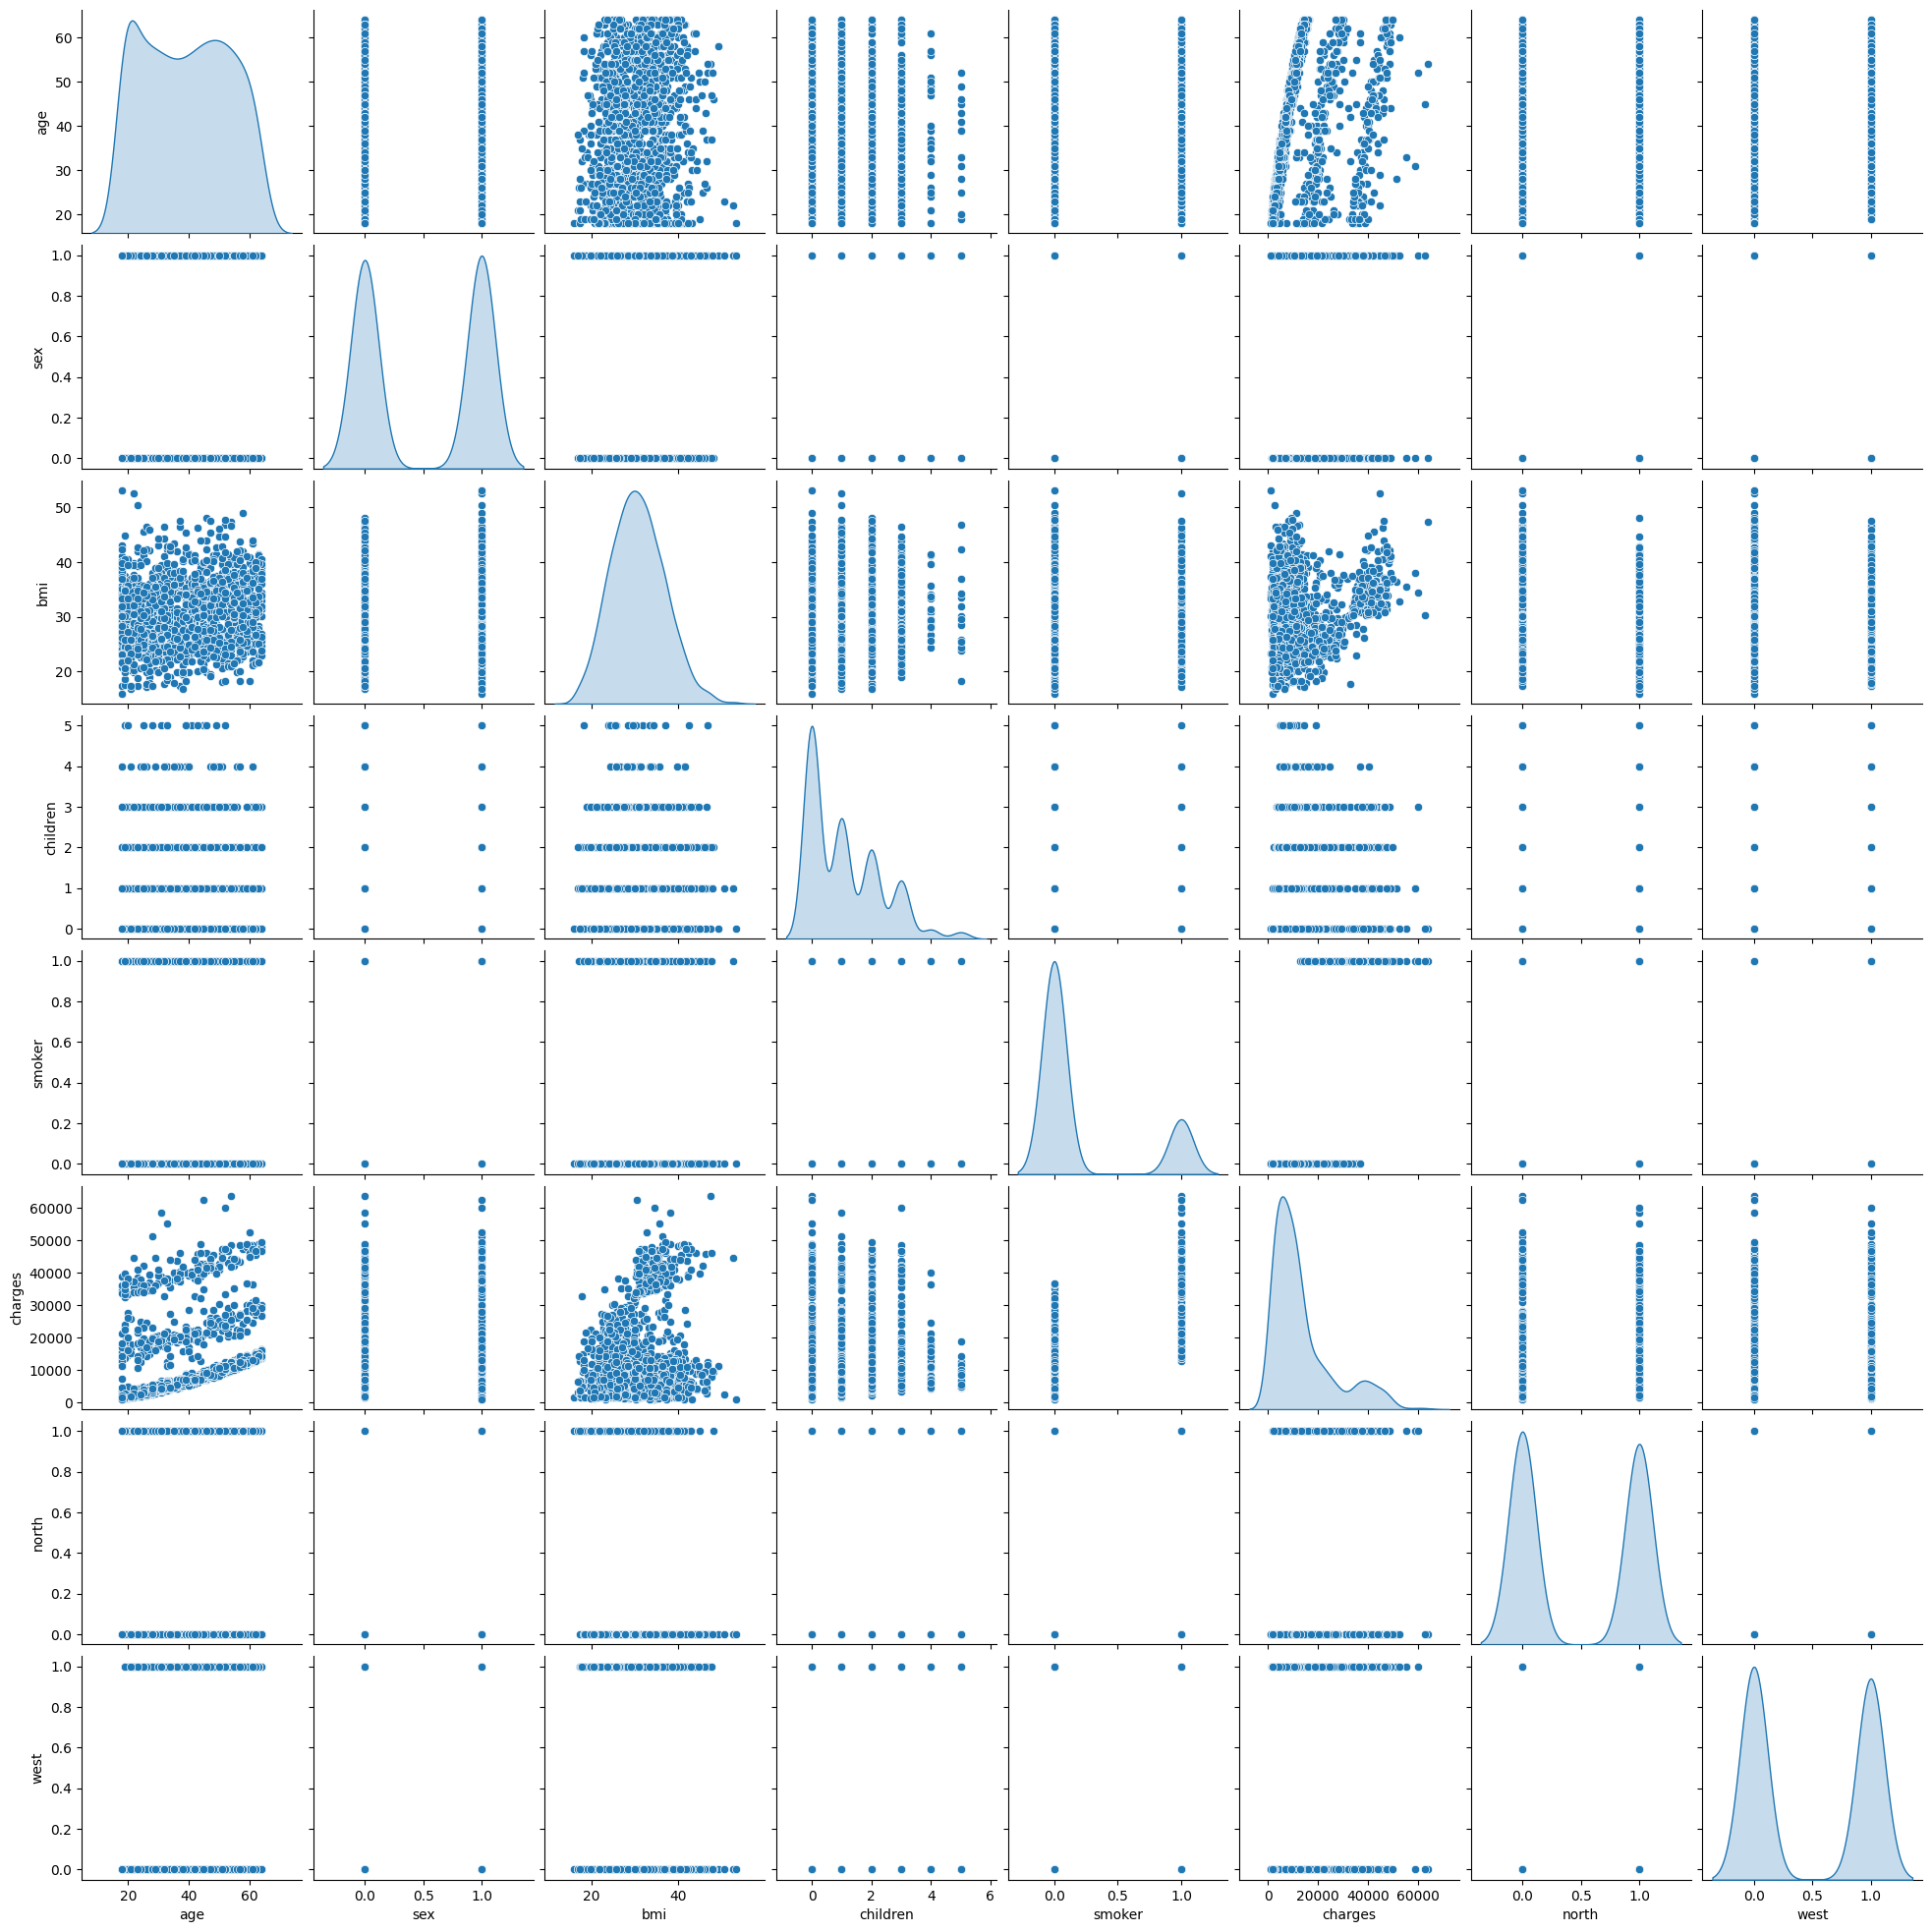

In [8]:
sns.pairplot(numerical_insurance, diag_kind='kde')


b. Observing the scatter plots between each feature and the dependent variable.

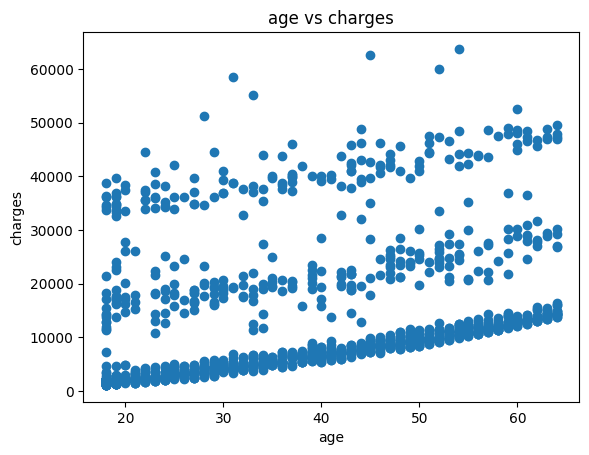

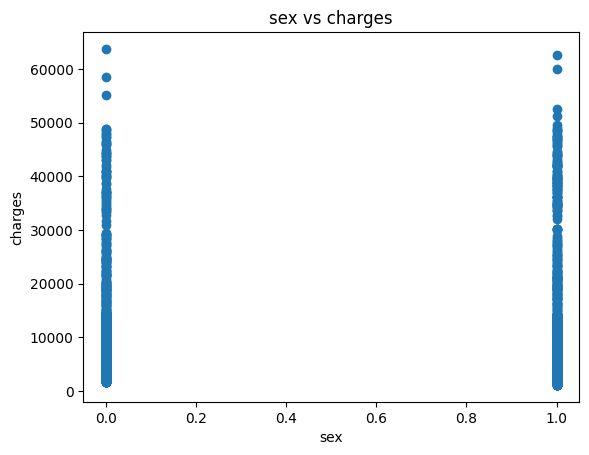

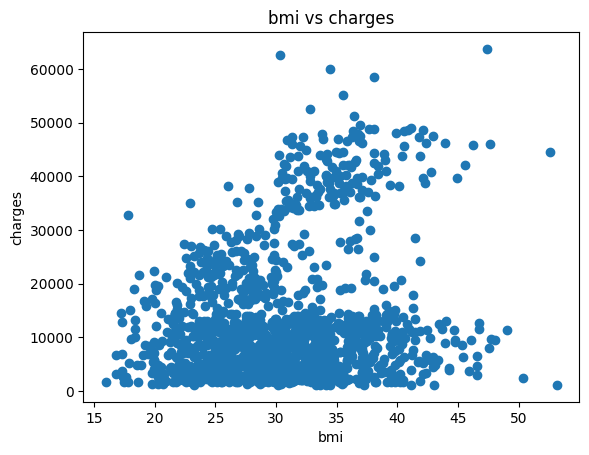

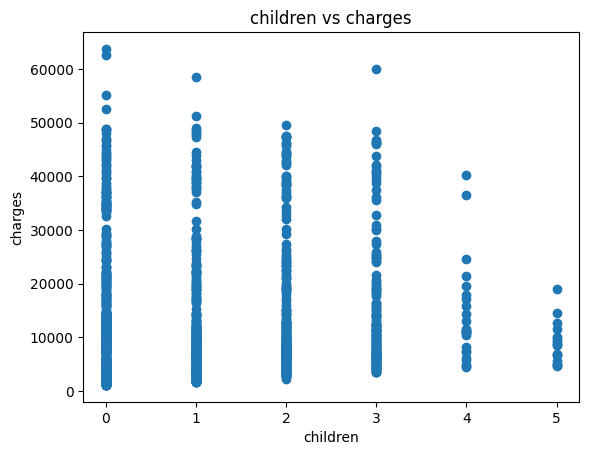

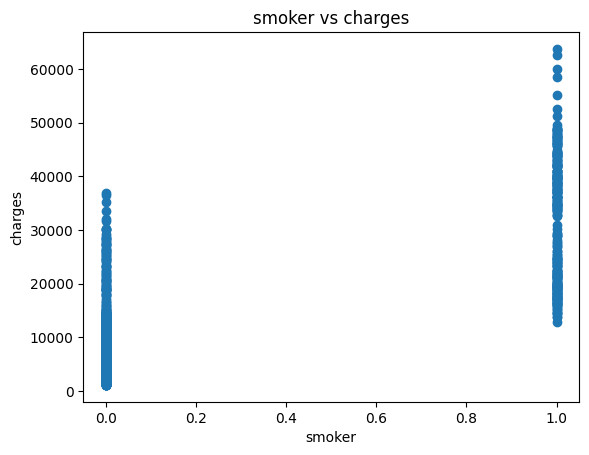

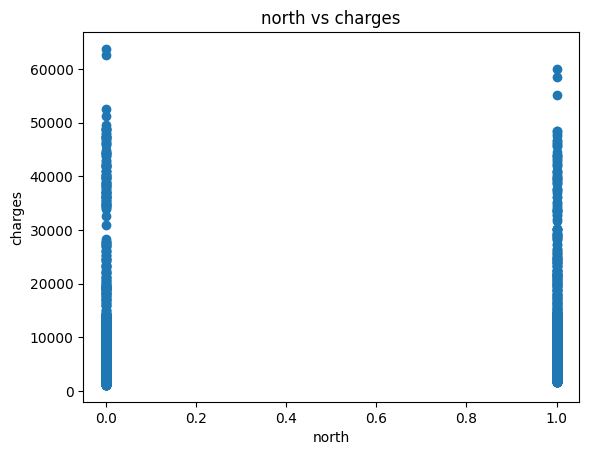

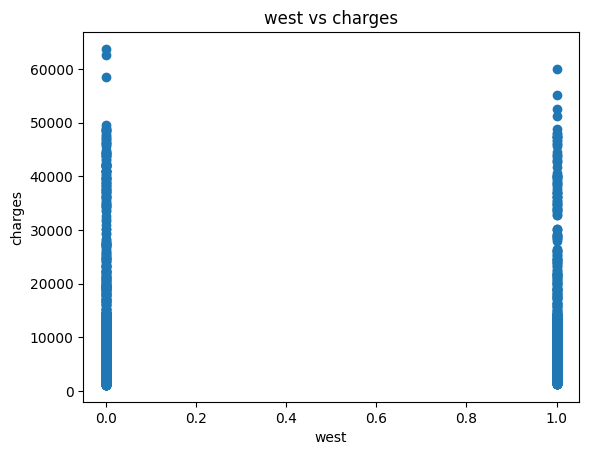

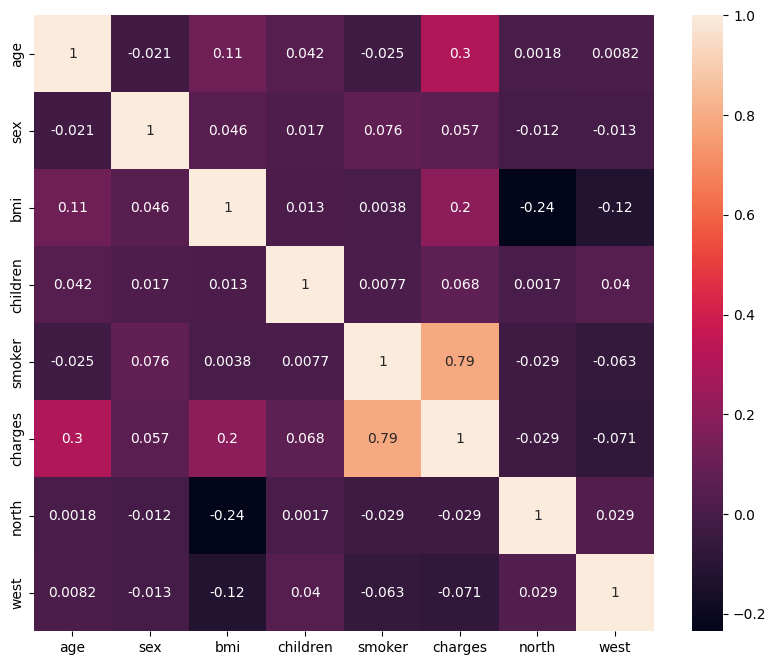

In [9]:
def plot_dependent_var_scatters(df, y):
  for i in range(len(df.columns)):
    if df.columns[i] == y:
      continue
    plt.figure()
    plt.scatter(df.iloc[:,i], df[y])
    plt.xlabel(df.columns[i])
    plt.ylabel(y)
    plt.title(f"{df.columns[i]} vs {y}")
    plt.show()
    print()

plot_dependent_var_scatters(numerical_insurance, "charges")

# Compute correlations
corr = numerical_insurance.corr()

# Draw heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.show()

3. Implement the “linear_regression.py” script, that obtains the best model, according to gradient descent.

([13270.422265141253], [3610.0112628435686, -65.34377845510527, 2054.254845599649, 572.948922567627, 9620.942089892316, 410.0037452681326, -68.19424035104777])


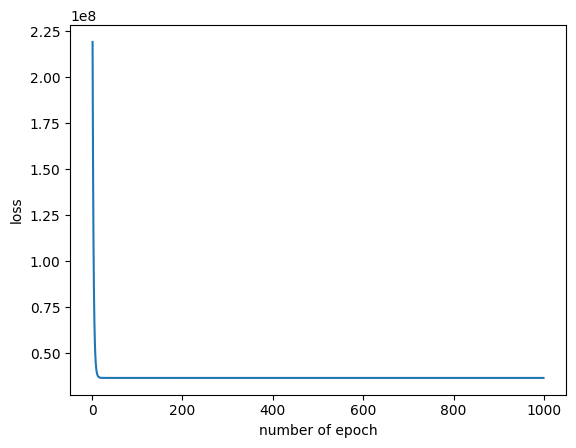

In [10]:
#https://medium.com/analytics-vidhya/implementing-gradient-descent-for-multi-linear-regression-from-scratch-3e31c114ae12
from itertools import accumulate

def fit_transform(X):
  mean = np.mean(X, axis=0)
  scale = np.std(X, axis=0)
  return (X - mean) / scale

class GradientDescent:
  def __init__(self, learning_rate, epochs):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.intercept = 0
    self.weight_vector = []
    self.linear_loss = []

  def loss(self, y, y_predicted):
    n = len(y)
    s = sum([(y[i]-y_predicted[i])**2 for i in range(n)])
    return (1/n) * s

  def get_weights(self, x, y, y_predicted):
    n=len(y)
    s = sum([-x[i]*(y[i] - y_predicted[i]) for i in range(n)])
    return (2/n) * s

  def get_bias(self, y, y_predicted):
    n = len(y)
    s = sum([-(y[i] - y_predicted[i]) for i in range(len(y))])
    return (2/n) * s

  def descend(self, X, y):
    y_predicted = self.predict(X)
    self.weight_vector -= self.learning_rate * self.get_weights(X, y, y_predicted)
    self.intercept -= self.learning_rate * self.get_bias(y, y_predicted)
    self.linear_loss.append(self.loss(y, y_predicted))

  def fit(self, X, y):
    self.weight_vector = np.random.randn(X.shape[1])
    for i in range(self.epochs):
      self.descend(X, y)
    return [self.intercept], list(self.weight_vector)

  def predict(self, X):
    y_hat = [self.weight_vector @ X[i] + self.intercept for i in range(len(X))]
    return np.array(y_hat)

  def plot_loss(self):
    plt.plot(np.arange(1, self.epochs), self.linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")

def plot_regression(X, y, alpha = 0.1, iterations = 1000):
  gd = GradientDescent(alpha, iterations)
  theta = gd.fit(X, y)
  gd.plot_loss()
  print(theta)

X = fit_transform(numerical_insurance.drop('charges', axis=1)).values
y = numerical_insurance["charges"].values

plot_regression(X, y)



4. Implement functions to obtain performance measures according to a “k-fold” validation scheme.





In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor

def kfold(X, y, k, show_results = False, show_loss = False, model = None):
  kf = KFold(n_splits=k, shuffle=False)
  # Initialize variables to store results
  r2_scores = []
  mse_scores = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if model == "SGDRegressor":
      model = SGDRegressor(alpha=0.1)
    else:
      model = GradientDescent(0.1, 1000)
    model.fit(X_train, y_train)
    if show_loss and model.plot_loss:
      model.plot_loss()
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)
  if show_results:
    print(f'MSE for each fold: {mse_scores}')
    print(f'Average MSE: {np.mean(mse_scores)}')
    print(f'R^2 for each fold: {r2_scores}')
    print(f'Average R^2: {np.mean(r2_scores)}')
  #return mse_scores, r2_scores

kfold(X, y, 5, True)

MSE for each fold: [37096097.16684171, 38011210.454105504, 32601828.5613847, 39635673.04813475, 37152145.16170198]
Average MSE: 36899390.87843373
R^2 for each fold: [0.7612826234113041, 0.7073454593052251, 0.7778658675361658, 0.7330019858194108, 0.75539937192153]
Average R^2: 0.7469790615987272


5. Analyze the differences in performance between the models obtained for the different
folds.

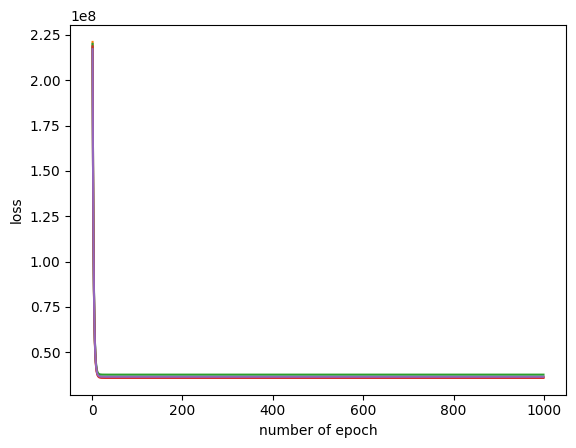

In [12]:
# Perform cross-validation
kfold(X, y, 5, False, True)

6. Adapt the “linear_regression.py script to fit a polynomial model (of order “p”) to your data. Repeat the analysis of step 5.

In [13]:
from itertools import combinations_with_replacement

def generate_polynomial_features(X, degree):
  n_samples, n_features = np.shape(X)
  comb = combinations_with_replacement(range(n_features), degree)
  features = [np.prod(X[:, list(comb)], axis=1) for comb in comb]
  return np.column_stack(features)


X_poly = generate_polynomial_features(X, degree=2)

print("STANDARD:")
kfold(X, y, 5, True)
print()
print("POLYNOMIAL:")
kfold(X_poly, y, 5, True)

# Using sklearn SGDRegressor for comparison purposes
print("SKLEARN SGDRegressor STANDARD:")
kfold(X, y, 5, True, False, "SGDRegressor")
print()
print("SKLEARN SGDRegressor POLYNOMIAL:")
kfold(X_poly, y, 5, True, False, "SGDRegressor")


STANDARD:
MSE for each fold: [37096097.16684171, 38011210.454105504, 32601828.5613847, 39635673.04813475, 37152145.16170198]
Average MSE: 36899390.87843373
R^2 for each fold: [0.7612826234113041, 0.7073454593052251, 0.7778658675361658, 0.7330019858194108, 0.75539937192153]
Average R^2: 0.7469790615987272

POLYNOMIAL:
MSE for each fold: [43053815.7700792, 41944975.453553446, 39606233.82345384, 45438116.388335794, 42870339.33759992]
Average MSE: 42582696.15460445
R^2 for each fold: [0.7229440631842793, 0.6770587576884846, 0.7301410142082223, 0.6939149531014948, 0.7177521814077209]
Average R^2: 0.7083621939180403
SKLEARN SGDRegressor STANDARD:
MSE for each fold: [37933751.54310199, 38011210.454105504, 32601828.5613847, 39635673.04813475, 37152145.16170198]
Average MSE: 37066921.75368579
R^2 for each fold: [0.7558922273734257, 0.7073454593052251, 0.7778658675361658, 0.7330019858194108, 0.75539937192153]
Average R^2: 0.7459009823911515

SKLEARN SGDRegressor POLYNOMIAL:
MSE for each fold: [4